<font size=5> **[넷플릭스 데이터를 활용한 추천 시스템 개발]** </font>
- netflix_titles.csv 데이터를 활용하여 주요 데이터 시각화 및 추천 시스템을 개발하시오
- 각 마크다운 셀의 내용을 참고하여 비어있는 코드 셀에 코드를 작성한다.
- 제시된 아웃풋은 참고이며 반드시 동일할 필요는 없다.

# 데이터 로딩

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_csv('./netflix_titles.csv')
print(df.shape)
display(df.head())

(7787, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


# 주요 데이터 시각화

## TV Show vs Movies (콘텐츠 타입) 막대 그래프

In [3]:
df['type'].value_counts().sort_values()

type
TV Show    2410
Movie      5377
Name: count, dtype: int64

In [4]:
index = df['type'].value_counts().sort_values().index.values.tolist()
type = df['type'].value_counts().sort_values().values.tolist()
print(index)
print(type)

['TV Show', 'Movie']
[2410, 5377]


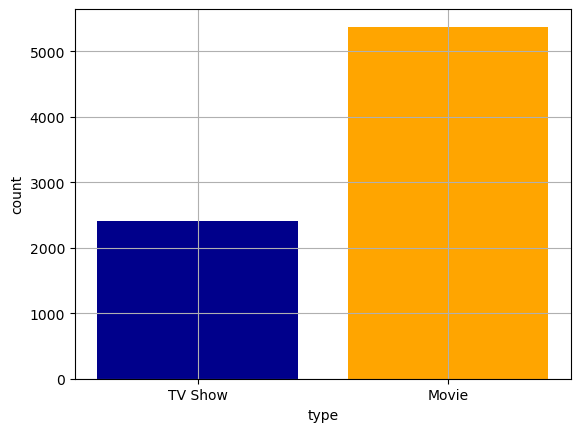

In [5]:
plt.bar(index,type, color=['darkblue','orange'])
plt.xlabel('type')
plt.ylabel('count')
plt.grid()
plt.show()

[참고]
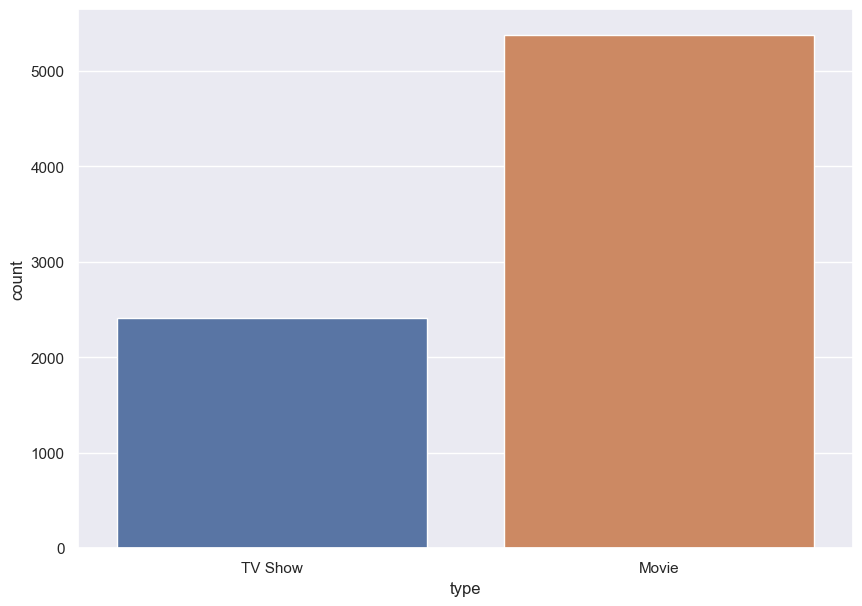

## 제작 국가별 수평 막대 그래프
- 결측 값 확인 및 결측 값을 포함한 레코드 삭제
- 2개 이상의 제작국가 값을 가지고 있는 레코드는 ‘,’를 기준으로 분류하여 카운팅 한다.
- 상위 10개국에 대한 막대그래프를 그린다.

### 결측값 확인 및 결측 값 레코드 삭제

In [ ]:
# 결측치가 존재하는 행을 제거 후 나라 추출 

In [6]:
new_df = df.copy()

In [7]:
print(new_df.isna().sum())

show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64


In [8]:
new_df = df.dropna()
print(new_df.isna().sum())

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


### 제작국가 분리

In [12]:
new_df[['country']].sample(5)

,country
3398,"China, United States, Australia"
7409,"Lebanon, Qatar"
337,Taiwan
6518,United States
387,United States


In [13]:
country = new_df['country']
aa=[]
for i in country: 
    for j in i.split(','):
        j = j.strip() 
        if j: 
            aa.append(j)

In [14]:
sorted(Counter(aa).items(), key = lambda ziped: ziped[1],reverse=True)[:10]

[('United States', 2181),
 ('India', 891),
 ('United Kingdom', 426),
 ('Canada', 263),
 ('France', 254),
 ('Spain', 147),
 ('Germany', 143),
 ('Japan', 108),
 ('China', 98),
 ('Egypt', 95)]

In [15]:
# 이름 등장 수를 기준으로 오름차순 정렬
count_countrys = sorted(Counter(aa).items(), key = lambda ziped: ziped[1])

In [16]:
# 상위 10개국 추출
names = [i for i, v in count_countrys[-10:]]
counts = [v for i, v in count_countrys[-10:]]

print(names)
print(counts)

['Hong Kong', 'China', 'Japan', 'Germany', 'Spain', 'France', 'Canada', 'United Kingdom', 'India', 'United States']
[95, 98, 108, 143, 147, 254, 263, 426, 891, 2181]


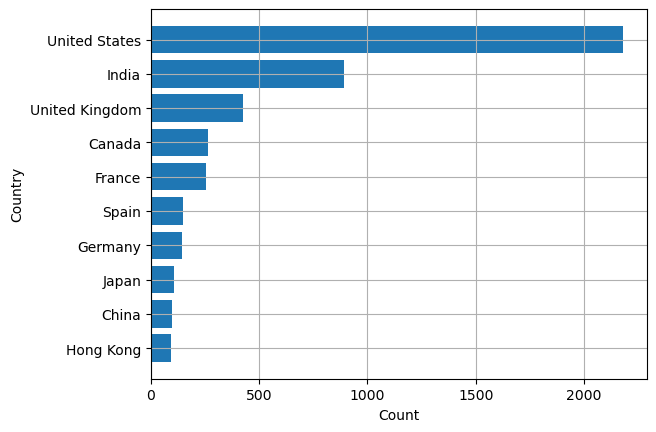

In [17]:
plt.barh(names,counts)
plt.xlabel('Count')
plt.ylabel('Country')
plt.grid()
plt.show()

[참고]
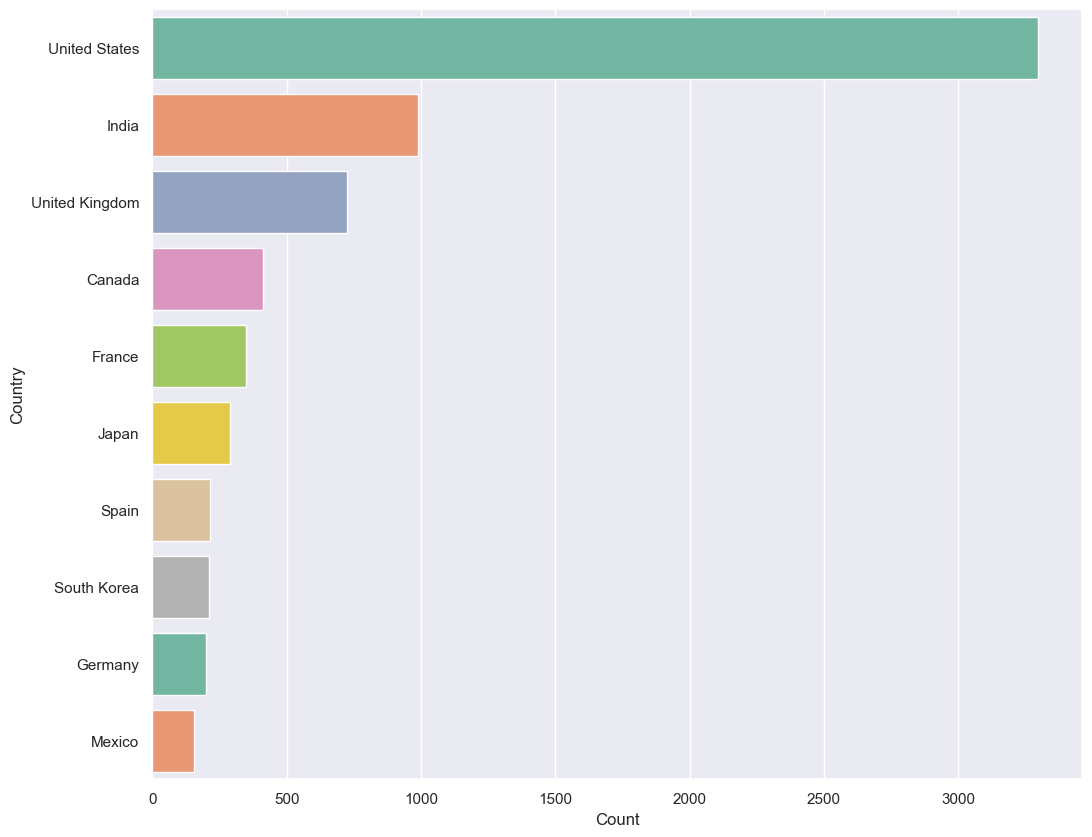

# 제목, 장르, 요약내용 특성 값을 기반으로 한 콘텐츠 기반 필터링 추천

## 데이터 전처리

### 추천 알고리즘 분석과 관련한 컬럼만 추출
- 추출 대상 컬럼: 'show_id', 'title', 'listed_in', 'description'    

In [18]:
netflix_df = df[['show_id', 'title', 'listed_in', 'description']]
display(netflix_df.head())

,show_id,title,listed_in,description
0,s1,3%,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,7:19,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,23:59,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,9,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,21,Dramas,A brilliant group of students become card-coun...


In [19]:
netflix_df.sample(5)

,show_id,title,listed_in,description
4218,s4219,Monty Python's Life of Brian,"Classic Movies, Comedies, Cult Movies","Born in a stable in Judea, Brian grows up to j..."
7457,s7458,"Wait, My Youth","International TV Shows, Romantic TV Shows, Tee...",Six hopeful friends journey into adulthood to ...
6134,s6135,The Birth Reborn 3,"Documentaries, International Movies",This intimate look at a São Paulo birth center...
6861,s6862,The Seventies,Docuseries,"This series examines 1970s America, focusing o..."
1358,s1359,Christian Mingle,"Comedies, Faith & Spirituality, Romantic Movies",A career woman who has everything but romance ...


In [20]:
netflix_df.isna().sum()

show_id        0
title          0
listed_in      0
description    0
dtype: int64

### DTM(Document Term Matrix) 생성
- title, listed_in, description 컬럼에 대해 피쳐 카운터 백터를 생성한다.
    - CounterVectorizer 또는 TfidfVectorizer 클래스를 이용한다.
    - nltk 라이브러리의 stopwords 패키지와 string 패키지의 punctuation을 합쳐 불용어 목록을 만들어 구두점 및 불용어를 제거한다.
    - title, listed_in, description 각 컬럼의 피처 벡터화한 결과를 **matrix_netflix_vocab = []** 리스트에 저장한다.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords 
import string 

# 불용어 목록 생성
stop_word = list(string.punctuation)+stopwords.words('english')
print(stop_word)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when'

In [22]:
# 각 컬럼의 피처 벡터화한 결과를 matrix_netflix_vocab = [] 리스트에 저장
title_vect = CountVectorizer(stop_words=stop_word)
listed_in_vect = CountVectorizer(stop_words=stop_word)
description_vect = CountVectorizer(stop_words=stop_word)

matrix_netflix_vocab = [] 
matrix_netflix_vocab.append(title_vect.fit_transform(netflix_df['title']))
matrix_netflix_vocab.append(listed_in_vect.fit_transform(netflix_df['listed_in']))
matrix_netflix_vocab.append(description_vect.fit_transform(netflix_df['description']))

In [23]:
print(matrix_netflix_vocab[0].shape)
print(matrix_netflix_vocab[1].shape)
print(matrix_netflix_vocab[2].shape)

(7787, 8147)
(7787, 44)
(7787, 18036)


In [24]:
# title의 피처 벡터화 결과
print(matrix_netflix_vocab[0][:10])

  (1, 23)	1
  (2, 62)	1
  (2, 102)	1
  (4, 59)	1
  (5, 92)	1
  (6, 10)	1
  (7, 20)	1
  (8, 110)	1
  (9, 26)	1


In [25]:
# title의 사전 목록
title_vect.vocabulary_

{'19': 23,
 '23': 62,
 '59': 102,
 '21': 59,
 '46': 92,
 '122': 10,
 '187': 20,
 '706': 110,
 '1920': 26,
 '1922': 27,
 '1983': 32,
 '1994': 40,
 '215': 60,
 '3022': 75,
 'oct': 5242,
 '01': 2,
 'feb': 2537,
 '09': 3,
 '22': 61,
 'jul': 3798,
 '15': 16,
 'aug': 537,
 '89': 115,
 'kuch': 4087,
 'bheege': 819,
 'alfaaz': 289,
 'goli': 2963,
 'soda': 6798,
 'maj': 4501,
 'rati': 5962,
 'keteki': 3937,
 'mayurakshi': 4680,
 'saint': 6335,
 'seiya': 6511,
 'knights': 4032,
 'zodiac': 8092,
 'error': 2372,
 'un': 7573,
 'well': 7882,
 'alive': 299,
 'annefrank': 397,
 'parallel': 5444,
 'stories': 6982,
 'blackaf': 886,
 'cats_the_mewvie': 1299,
 'friendbutmarried': 2743,
 'realityhigh': 5983,
 'roxy': 6257,
 'rucker50': 6264,
 'selfie': 6518,
 '69': 109,
 'แผนร': 8137,
 'ายนายเจ': 8135,
 'าเล': 8136,
 'ay': 573,
 'mi': 4781,
 'madre': 4465,
 'çarsi': 8115,
 'pazar': 5513,
 'ég': 8117,
 'man': 4536,
 'þig': 8125,
 'çok': 8116,
 'filim': 2587,
 'hareketler': 3172,
 'bunlar': 1131,
 'òlòtūré':

# 콘텐츠 유사도 측정

- title, listed_in, description 각 컬럼에 대해 피처 백터화 한 값을 이용하여 각각의 코사인 유사도를 산출하여 **matrix_netflix_sim = []** 리스트에 저장한다.

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
# title의 코사인 유사도
title_sim = cosine_similarity(matrix_netflix_vocab[0],matrix_netflix_vocab[0])
print(title_sim.shape)
print(title_sim[:3])

(7787, 7787)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [28]:
# listed_in의 코사인 유사도
listed_in_sim = cosine_similarity(matrix_netflix_vocab[1],matrix_netflix_vocab[1])
print(listed_in_sim.shape)
print(listed_in_sim[:3])

(7787, 7787)
[[1.         0.2981424  0.10540926 ... 0.11547005 0.78072006 0.        ]
 [0.2981424  1.         0.70710678 ... 0.51639778 0.21821789 0.        ]
 [0.10540926 0.70710678 1.         ... 0.54772256 0.15430335 0.        ]]


In [29]:
# ddescription의 코사인 유사도
description_sim = cosine_similarity(matrix_netflix_vocab[2],matrix_netflix_vocab[2])
print(description_sim.shape)
print(description_sim[:3])

(7787, 7787)
[[1.         0.         0.06900656 ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.13801311 0.         0.        ]
 [0.06900656 0.         1.         ... 0.         0.         0.        ]]


- title, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스를 **netflix_sim_sorted_ind = []** 리스트에 저장한다.

In [30]:
netflix_sim_sorted_ind = [] 
netflix_sim_sorted_ind.append(title_sim.argsort(axis=1)[:,::-1]) #title
netflix_sim_sorted_ind.append(listed_in_sim.argsort(axis=1)[:,::-1])  #listed_in
netflix_sim_sorted_ind.append(description_sim.argsort(axis=1)[:,::-1]) #description

In [31]:
# 0번째 title에 대한 title 유사도 상위 10개
print(netflix_sim_sorted_ind[0][0,:10])

[7786 2615 2587 2588 2589 2590 2591 2592 2593 2594]


In [32]:
target = netflix_df[netflix_df['title']=='Reply 1988'] 
title_index = target.index.values
print(netflix_sim_sorted_ind[0][title_index,:10])

print(netflix_df.iloc[5161,:]['title']) # 자기 자신
print(netflix_df.iloc[5162,:]['title']) # 가장 제목이 유사한 것 1

[[5161 5162 5163 2599 2598 2597 2596 2595 2594 7786]]
Reply 1988
Reply 1994


# 유사도 필터링을 이용한 넷플릭스 콘텐츠 추천

- 추천 기준이 되는 콘텐츠의 제목으로 해당 콘텐츠의 netflix_df 데이터 프레임에서의 레코드 인덱스를 추출한다.
- 해당 인덱스로 sorted_ind_list 인자로 입력된 netflix_sim_sorted_ind 객체에서 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 후 리스트에 저장한다.
- 함수 매개변수
    - df: 넷플릭스 콘텐츠 정보 DataFrame
    - sorted_ind_list: title, listed_in, description에 대해 각각 유사도가 높은 순으로 정렬한 콘텐츠의 인덱스 행렬을 저장한 리스트
    - title_name: 추천 기준이 되는 콘텐츠 제목 (해당 콘텐츠와 장르 유사도가 높은 콘텐츠를 추천)
    - top_n: 추천 콘텐츠 건수

In [33]:
def find_sim_netflix(df, sorted_ind_list, title_name, top_n=10):
    target = netflix_df[netflix_df['title']==title_name] 
    title_index = target.index.values
    
    # 각 컬럼별 유사도 순으로 top_n 개의 index를 추출한 행렬을 저장할 리스트
    similar_indexes_list = [i[title_index,:top_n].reshape(-1) for i in sorted_ind_list]
    # similar_indexes_list = []
    # for sorted_ind in sorted_ind_list: 
    #     similar_indexes_list.append(sorted_ind[title_index,:top_n])
    
    # 데이터 프레임의 인덱스 값으로 사용하기 위해 1차원 데이터로 변환한다.
    return df.iloc[np.array(similar_indexes_list).flatten()]

In [34]:
# '응답하라 1988' 과 제목, 장르, 줄거리가 유사한 콘텐츠를 각각 10개씩 추천
similar_netflix = find_sim_netflix(netflix_df, netflix_sim_sorted_ind, 'Reply 1988',10)

In [163]:
display(similar_netflix[['title']])

,title
5161,Reply 1988
5162,Reply 1994
5163,Reply 1997
2599,Hannah Gadsby: Nanette
2598,Hannah Gadsby: Douglas
2597,Hank: Five Years from the Brink
2596,Hangman
2595,Hangar 1: The UFO Files
2594,Handsome: A Netflix Mystery Movie
7786,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS
